# Homework – Decision Trees & Ensembles (Car Fuel Efficiency)

Goal: Predict `fuel_efficiency_mpg` from car attributes using tree-based models.

Steps:
1. Prep data: fill missing with 0, 60/20/20 split
2. DictVectorizer(sparse=True)
3. Q1 – DecisionTreeRegressor(max_depth=1)
4. Q2 – RandomForestRegressor(n_estimators=10)
5. Q3 – Sweep n_estimators 10..200
6. Q4 – Sweep max_depth ∈ [10, 15, 20, 25]
7. Q5 – Feature importance from RF
8. Q6 – XGBoost (eta 0.3 vs 0.1)

In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display

In [26]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

# make columns lowercase and strip whitespace
df.columns = df.columns.str.strip().str.lower()

target = "fuel_efficiency_mpg"

In [27]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [28]:
# fill missing values with zeros
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].fillna('')        # fill with blanks
    else:
        df[c] = df[c].fillna(0)         # numeric -> 0

In [29]:
df.describe()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,3.765664,138.738355,3001.280993,13.582275,2011.484027,-0.006080,14.985243
std,49.455319,2.130715,48.401189,497.894860,5.025294,6.659808,1.020689,2.556468
min,10.000000,0.000000,0.000000,952.681761,0.000000,2000.000000,-4.000000,6.200971
25%,170.000000,2.000000,124.000000,2666.248985,12.600000,2006.000000,-1.000000,13.267459
50%,200.000000,4.000000,146.000000,2993.226296,14.700000,2012.000000,0.000000,15.006037
75%,230.000000,5.000000,168.000000,3334.957039,16.500000,2017.000000,1.000000,16.707965
max,380.000000,13.000000,271.000000,4739.077089,24.300000,2023.000000,4.000000,25.967222


## Split the Data

In [30]:
# 1) 80/20
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1
)

# 2) 60/20 out of the 80
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,    # 0.25 * 0.8 = 0.2
    random_state=1
)

for d in (df_full_train, df_train, df_val, df_test):
    d.reset_index(drop=True, inplace=True)

y_train = df_train[target].values
y_val   = df_val[target].values

X_train_df = df_train.drop(columns=[target])
X_val_df   = df_val.drop(columns=[target])

## Encoding variables with DictVectorizer -- (sparse=True)

In [31]:
dv = DictVectorizer(sparse=True)

train_dicts = X_train_df.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = X_val_df.to_dict(orient="records")
X_val = dv.transform(val_dicts)

## Question 1: Train a decision tree regressor to predict the fuel_efficiency_mpg variable. Train a model with max_depth=1.


In [32]:
dt = DecisionTreeRegressor(
    max_depth=1,
    random_state=1
)
dt.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
root_feature_index = dt.tree_.feature[0]
root_feature_name = feature_names[root_feature_index]
root_feature_name

'vehicle_weight'

## Question 2 — Random Forest, RMSE
Train a random forest regressor with these parameters:
* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?




In [33]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)

# Calculate RMSE
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
rmse.round(3)

0.459

## Question 3 — n_estimators sweep
Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [34]:
n_values = list(range(10, 201, 10))   # 10, 20, 30, ..., 200

rmse_by_n = []
best_rmse_rounded = None
best_n = None

for n in n_values:
    m = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    m.fit(X_train, y_train)
    y_pred = m.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse_n = np.sqrt(mse)

    rmse_by_n.append((n, rmse_n))

    # round to 3 decimals for "stop improving" logic
    r3 = round(rmse_n, 3)
    if best_rmse_rounded is None or r3 < best_rmse_rounded:
        best_rmse_rounded = r3
        best_n = n

rmse_by_n, best_n, best_rmse_rounded

([(10, 0.45866154584849067),
  (20, 0.45367991021440807),
  (30, 0.45117160299870146),
  (40, 0.4483573590280683),
  (50, 0.44617922938257604),
  (60, 0.44529984913635223),
  (70, 0.4446744627744229),
  (80, 0.4449936429447334),
  (90, 0.44520450225183406),
  (100, 0.44489583217008744),
  (110, 0.4437175613239898),
  (120, 0.4441005815461587),
  (130, 0.44377294406185214),
  (140, 0.4435015066774845),
  (150, 0.44302004101617776),
  (160, 0.44278873172443844),
  (170, 0.44289406184846236),
  (180, 0.4425481225333085),
  (190, 0.442606534659465),
  (200, 0.4425198344580456)],
 150,
 0.443)

## Question 4 — best max_depth
Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values,
  * try different values of n_estimators from 10 till 200 (with step 10)
  * calculate the mean RMSE
* Fix the random seed: random_state=1
  
What's the best max_depth, using the mean RMSE?

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scores = []

for depth in [10, 15, 20, 25]:
    for n in list(range(10, 201, 10)) :
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((depth, n, rmse_val))

df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "rmse"])

df_scores_pivot = df_scores.pivot(
    index="n_estimators",
    columns="max_depth",
    values="rmse"
).round(3)

df_scores_pivot

max_depth,10,15,20,25
n_estimators,,,,
10,0.451,0.458,0.459,0.459
20,0.447,0.453,0.453,0.454
30,0.446,0.451,0.452,0.451
40,0.443,0.448,0.449,0.448
50,0.442,0.446,0.447,0.446
60,0.442,0.445,0.445,0.445
70,0.441,0.445,0.445,0.444
80,0.442,0.445,0.445,0.445
90,0.442,0.445,0.445,0.445


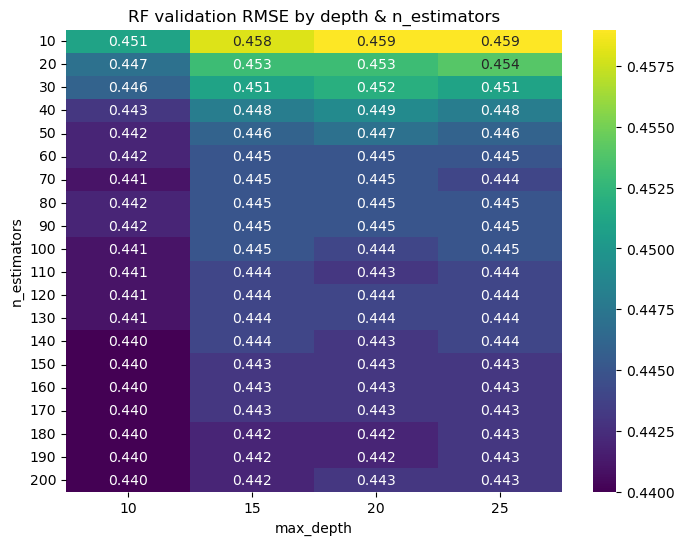

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("RF validation RMSE by depth & n_estimators")
plt.show()

In [48]:
depth_table = (
    df_scores.groupby("max_depth")["rmse"]
    .mean().round(4)
    .sort_values()
)

best_depth = (
    df_scores.groupby("max_depth")["rmse"]
    .mean().round(4)
    .sort_values()
    .idxmin()
)
display(depth_table)
print("Best Max Depth:",best_depth)

max_depth
10    0.4419
15    0.4456
20    0.4457
25    0.4457
Name: rmse, dtype: float64

Best Max Depth: 10


## Question 5 — feature importances from RF

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * n_estimators=10,
  * max_depth=20,
  * random_state=1,
  * n_jobs=-1 (optional)
  
* Get the feature importance information from this model
  
What's the most important feature (among these 4)?

* vehicle_weight
* horsepower
* acceleration
* engine_displacement

In [41]:
rf_imp = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf_imp.fit(X_train, y_train)

importances = rf_imp.feature_importances_
feat_names = dv.get_feature_names_out()

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

imp_df.head(30)

,feature,importance
13,vehicle_weight,0.959153
6,horsepower,0.016066
0,acceleration,0.011490
3,engine_displacement,0.003279
7,model_year,0.003170
8,num_cylinders,0.002333
9,num_doors,0.001618
12,origin=USA,0.000546
11,origin=Europe,0.000513
10,origin=Asia,0.000454


## Question 6 — XGBoost: eta 0.3 vs 0.1

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [42]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [43]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# ----- eta = 0.3 -----
params_03 = params.copy()
params_03['eta'] = 0.3

model_03 = xgb.train(
    params_03,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=False
)

y_val_pred_03 = model_03.predict(dval)
rmse_03 = rmse(y_val, y_val_pred_03)

# ----- eta = 0.1 -----
params_01 = params.copy()
params_01['eta'] = 0.1

model_01 = xgb.train(
    params_01,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=False
)

y_val_pred_01 = model_01.predict(dval)
rmse_01 = rmse(y_val, y_val_pred_01)

print("eta 0.3 RMSE:",rmse_03.round(4))
print("eta 0.1 RMSE:",rmse_01.round(4))

eta 0.3 RMSE: 0.4502
eta 0.1 RMSE: 0.4262
